In [3]:
!pip install lightgbm

     |████████████████████████████████| 1.8 MB 9.6 MB/s eta 0:00:01


In [5]:
!pip install mne_features

     |████████████████████████████████| 6.8 MB 9.8 MB/s eta 0:00:01


In [6]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb 

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)

<module 'Components.feature_extraction' from '../Components/feature_extraction.py'>

# Data Fetching

In [13]:
_, y = data_fetching.get_train_data()
y = np.ravel(y)

X = feature_extraction.get_features(None, precomputed='train')
X_test = feature_extraction.get_features(None, precomputed='test')

# Cross-validation

In [20]:
scaler = StandardScaler()
X_2 = scaler.fit_transform(X,y)

clf = lgb.LGBMClassifier(class_weight = 'balanced')

In [21]:
# 10-fold cross validation
cv_score = cross_val_score(clf, X_2, y, cv=10, scoring='balanced_accuracy', n_jobs=16)
print(cv_score)
print(np.mean(cv_score))

# Results
# Univariate:
# [0.89757557 0.92140442 0.93921128 0.93053365 0.92786127 0.94813602
#  0.94736384 0.93639493 0.92317302 0.90670064]
# 0.9278354652022862

# Univariate + Bivariate:
#[0.90347486 0.92410507 0.94056357 0.93016137 0.92783613 0.94582218
# 0.95304799 0.93762358 0.92989084 0.89881094]
#0.9291336524084614

#LGB balanced all MNE features
#[0.91248291 0.93757551 0.93776122 0.94559858 0.94700759 0.95800639
 #0.96195897 0.96088698 0.95638669 0.93146697]
#0.9449131810551336


[0.91248291 0.93757551 0.93776122 0.94559858 0.94700759 0.95800639
 0.96195897 0.96088698 0.95638669 0.93146697]
0.9449131810551336


In [22]:
# Train on 2 subjects, test on the other
n_epochs = 21600
splits = [(np.r_[0:2*n_epochs], np.r_[2*n_epochs:3*n_epochs]),
 (np.r_[0:n_epochs, 2*n_epochs:3*n_epochs], np.r_[n_epochs:2*n_epochs]),
 (np.r_[n_epochs:3*n_epochs], np.r_[0:n_epochs])]

# format: 
# [(train_indices, test_indices),
#    (train_indices, test_indices),....]

cv_score = cross_val_score(clf, X_2, y, cv=splits, scoring='balanced_accuracy',n_jobs=16)
print(cv_score)
print(np.mean(cv_score))

#LGB all MNE features
#[0.70943547 0.95720017 0.88320811]
#0.8499479178461647


[0.70943547 0.95720017 0.88320811]
0.8499479178461647


# Prediction

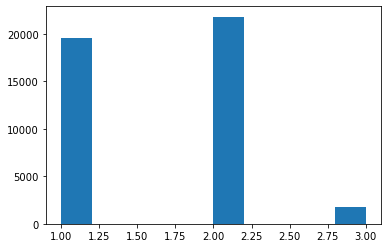

In [23]:
pipe = Pipeline([('scaling',StandardScaler()),
                 ('classification', lgb.LGBMClassifier(class_weight = 'balanced'))])

pipe.fit(X,y)
y_pred = pipe.predict(X_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/LGB_Standard_MNE_Features_All.csv', index_label='Id')